# License 
***
Copyright (C) 2017 J. Patrick Hall, jphall@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

***
# **Basic** Gradient Descent for Multiple Linear Regression

In [1]:
# imports 
import pandas as pd # import pandas for easy data manipulation using data frames
import numpy as np  # import numpy for numeric calculations on matrices
import time         # for timers

# import h2o to check calculations
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

#### Assign global constants

In [2]:
# data-related constants
IN_FILE_PATH = '../data/loan_clean.csv'
Y            = 'STD_IMP_REP_loan_amnt'
DROPS        = ['id', 'GRP_REP_home_ownership', 'GRP_addr_state', 'GRP_home_ownership',
                'GRP_purpose', 'GRP_verification_status', '_WARN_']

# model-related constants
LEARN_RATE   = 0.05 # how much each gradient descent step impacts parameters
CONV         = 1e-10 # desired precision in parameters 
MAX_ITERS    = 10000 # maximum number of gradient descent steps to allow

### Import clean data and convert to numpy matrices

In [3]:
# import data using Pandas
raw = pd.read_csv(IN_FILE_PATH)
raw.describe()

,id,bad_loan,GRP_REP_home_ownership,GRP_addr_state,GRP_home_ownership,GRP_purpose,GRP_verification_status,_WARN_,STD_IMP_REP_annual_inc,STD_IMP_REP_delinq_2yrs,STD_IMP_REP_dti,STD_IMP_REP_emp_length,STD_IMP_REP_int_rate,STD_IMP_REP_loan_amnt,STD_IMP_REP_longest_credit_lengt,STD_IMP_REP_revol_util,STD_IMP_REP_term_length,STD_IMP_REP_total_acc
count,163987.000000,163987.000000,163987.000000,163987.000000,163987.000000,163987.000000,163987.000000,0.0,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05
mean,91994.000000,0.192595,2.574003,11.409337,2.574003,3.244940,2.340356,NaN,2.387342e-11,2.408736e-12,6.806950e-11,-3.563309e-11,-8.939301e-12,8.310596e-11,5.061841e-11,-1.473947e-11,-1.500741e-10,8.045720e-13
std,47339.113634,0.394338,0.667526,9.971926,0.667526,2.267289,0.504086,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,10001.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,-1.767456e+00,-3.921962e-01,-2.119639e+00,-1.621390e+00,-1.907046e+00,-1.587129e+00,-2.224451e+00,-2.164541e+00,-5.164956e-01,-2.058862e+00
25%,50997.500000,0.000000,2.000000,3.000000,2.000000,2.000000,2.000000,NaN,-6.595203e-01,-3.921962e-01,-7.380602e-01,-7.663281e-01,-6.840838e-01,-7.667612e-01,-7.212383e-01,-7.235035e-01,-5.164956e-01,-7.471426e-01
50%,91994.000000,0.000000,3.000000,8.000000,3.000000,2.000000,2.000000,NaN,-2.225562e-01,-3.921962e-01,-2.257573e-02,8.873407e-02,-5.191344e-02,-2.114351e-01,-1.199531e-01,7.707309e-02,-5.164956e-01,-1.350069e-01
75%,132990.500000,0.000000,3.000000,17.000000,3.000000,3.000000,3.000000,NaN,3.686305e-01,-3.921962e-01,6.955785e-01,1.228817e+00,5.917510e-01,6.215541e-01,4.813321e-01,7.815805e-01,-5.164956e-01,5.645768e-01
max,173987.000000,1.000000,5.000000,37.000000,5.000000,14.000000,3.000000,NaN,4.618062e+00,4.156695e+00,3.037149e+00,1.228817e+00,2.837680e+00,2.767132e+00,3.143160e+00,3.036350e+00,1.971879e+00,3.068467e+00


In [4]:
# select target column
y = raw[Y].as_matrix()
print(y)

[-1.01918221 -1.33470843 -1.34732948 ... -0.03158515  1.83948532
  0.49534363]


In [5]:
# create input matrix
# add an additional column of 1's for intercept 
# by overlaying inputs onto matrix of 1's
numeric = raw.drop(DROPS + [Y], axis=1).as_matrix()
N, p = numeric.shape
X = np.ones(shape=(N, p + 1))
X[:,1:] = numeric 

### Linear Regression by Solving the Normal Equation 

\begin{equation}
X\hat{\beta} = y 
\end{equation}

\begin{equation}
\hat{\beta} = (X^{T}X)^{-1}X^Ty
\end{equation}

The normal equation estimates coefficients that globally minimize the squared error between a rectangular input data matrix $X$ and a column vector of target values $y$. I.e. it presents an optimal solution to an underspecified set of linear equations.

In [6]:
X_transpose = np.transpose(X)
beta_hat = np.linalg.inv(X_transpose.dot(X))
beta_hat = beta_hat.dot(X_transpose)
beta_hat = beta_hat.dot(y)
print('Model parameters:\n', beta_hat)

Model parameters:
 [-0.00953184  0.04949174  0.4184344  -0.04237427  0.08966404  0.0301429
  0.08011731  0.05023822  0.01554239  0.31239211  0.04139277]


### Basic Gradient Descent Routines with L2 ("Ridge"/"Tikhonov") Regularization
\begin{equation}
\hat{\beta} = \underset{\beta}{argmin}\sum_{i=1}^{N} (y_i - \beta x_i)^2 + \lambda\sum_{j=0}^p \beta^2_j
\end{equation}

#### Define squared loss function
* For linear regression, we directly minimize the squared distance between the regression plane and points in the conditional distribution of **y** given **X**.
* Direct minimization of the squared loss function is typically preferred to solving the normal equation directly due to numerical stability and scalability issues.
* It is convenient to use a scaled mean squared error (MSE) formula:
\begin{equation}
\frac{1}{2N}\sum_{i=1}^{N} (y_i - \beta x_i)^2
\end{equation}

In [7]:
def squared_loss(n, x, y, betas, lambda_=0):
    
    """ Squared loss function for multiple linear regression.
    
    :param n: Number of rows in x.
    :param x: Matrix of numeric inputs.
    :param y: Vector of known target values.
    :param beta: Vector of current model parameters.
    :param lambda_: Scale factor for L2 regularization, default 0.
    :return: Scalar MSE value.    
    
    """
    
    yhat = x.dot(betas)
        
    return (1 / (2 * n)) * (((y - yhat)**2).sum() + lambda_ * (betas**2).sum())

#### Define gradient of loss function
* The derivative of the loss function w.r.t the model parameters is used to update model parameters at each gradient descent step.
* The gradient of our MSE loss function is trivial:

In [8]:
def grad(n, y, yhat, x, beta_j, lambda_=0):
    
    """ Analytical gradient of scaled MSE loss function with L2 regularization.
    
    :param n: Number of rows in X.
    :param y: Vector of known target values.
    :param yhat: Vector of predicted target values.
    :param x: Vector of input values.
    :param beta_j: Model parameter for which to calculate gradient.
    :param lambda_: Scale factor for L2 regularization, default 0.
    :return: Vector of gradient values.
    
    """
    
    return (1 / n) * (x * (yhat - y) + (lambda_ * beta_j))

#### Define function for executing gradient descent minimization
For each gradient descent step:
* Predictions are made using the current model parameters.
* The gradient is calculated for each model pararmeter.
* The gradient is used in combination with the learning rate to update each parameter.

In [9]:
def grad_descent(X, y, learn_rate, max_iters, sgd_mini_batch_n=0, lambda_=0):
    
    """ Routine for executing simple gradient descent with stochastic gradient descent option.
    
    :param X: Matrix of numeric data.
    :param y: Vector of known target values.
    :param learn_rate: Learning rate.
    :param max_iters: Maximum number of gradient descent steps to perform.
    :param sgd_mini_batch_n: Minibatch size for sgd optimization.
                             If > 0 minibatch stochastic gradient descent is performed.
    :param lambda_: Scale factor for L2 regularization, default 0.
    
    """

    tic = time.time()               # start timer
    n_betas = X.shape[1]            # number of model parameters including bias    
    betas = np.zeros(shape=n_betas) # parameters start with value of 0
    n = y.shape[0]                  # number of rows in X
    
    # Pandas dataframe for iteration history
    iteration_frame = pd.DataFrame(columns=['Iteration', 'Loss'])

    print('Iteration history:')
    
    # loop for gradient descent steps
    for i in range(max_iters):
        
        # stochastic gradient descent
        if sgd_mini_batch_n > 0:
            
            samp_idx = np.random.randint(n, size=sgd_mini_batch_n)
            X_samp = X[samp_idx, :]
            y_samp = y[samp_idx]
            n_samp = X_samp.shape[0]
            yhat_samp = X_samp.dot(betas) # model predictions for iteration

            # loop for column-wise parameter updates
            for j in range(n_betas):

                # select column
                # calculate column-wise gradient
                # update corresponding parameter based on negative gradient
                # calculate loss

                xj_samp = X_samp[:, j]
                beta_j = betas[j]
                xj_grad_samp = grad(n_samp, y_samp, yhat_samp, xj_samp, beta_j, lambda_)
                betas[j] = betas[j] - learn_rate * xj_grad_samp.sum()
                iter_loss = squared_loss(n_samp, X_samp, y_samp, betas, lambda_)
        
        # standard gradient descent
        else:
            
            yhat = X.dot(betas) # model predictions for iteration

            # loop for column-wise parameter updates
            for j in range(n_betas):
                xj = X[:, j]
                beta_j = betas[j]
                xj_grad = grad(n, y, yhat, xj, beta_j, lambda_)
                betas[j] = betas[j] - learn_rate * xj_grad.sum()
                iter_loss = squared_loss(n, X, y, betas, lambda_)
        
        # update loss history
        iteration_frame = iteration_frame.append({'Iteration': i,
                                                  'Loss':  iter_loss}, 
                                                  ignore_index=True)        
        # progress indicator 
        if i % 1000 == 0:
            print('iter=%d loss=%.6f' % (i, iter_loss))
        
        # convergence check
        if i > 0:
            if np.abs(iteration_frame.iat[i-1, 1] - iteration_frame.iat[i, 1]) < CONV:
                break

    # output 
    %matplotlib inline
    iteration_frame.plot.line(title='Iteration Plot', x='Iteration', y='Loss')
    print()           
    print('Model parameters at iteration ' + str(i) + ':')
    print(betas)
    print()
    print('Model trained in %.2f s.' % (time.time()-tic))


#### Execute gradient descent

Iteration history:
iter=0 loss=0.472967

Model parameters at iteration 709:
[-0.00946269  0.04918263  0.41842662 -0.04237465  0.08967229  0.03014185
  0.08014273  0.05024078  0.01554251  0.3123994   0.04138562]

Model trained in 19.11 s.


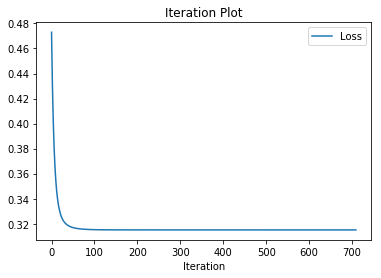

In [10]:
grad_descent(X, y, LEARN_RATE, MAX_ITERS)

#### Execute L2 penalized gradient descent

Iteration history:
iter=0 loss=0.472967

Model parameters at iteration 962:
[-0.00887026  0.04652247  0.41326281 -0.04186768  0.08725817  0.03035732
  0.08097103  0.050572    0.01624763  0.30948716  0.04325793]

Model trained in 27.56 s.


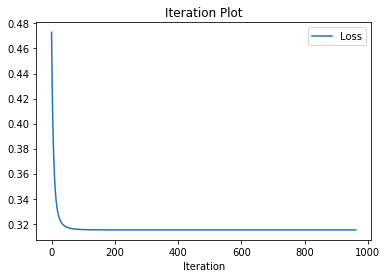

In [11]:
grad_descent(X, y, LEARN_RATE, MAX_ITERS, lambda_=0.01)

#### Execute stochastic gradient descent

Iteration history:
iter=0 loss=0.508994
iter=1000 loss=0.353958
iter=2000 loss=0.329552
iter=3000 loss=0.294881
iter=4000 loss=0.328536
iter=5000 loss=0.356125
iter=6000 loss=0.289613
iter=7000 loss=0.346587
iter=8000 loss=0.330513
iter=9000 loss=0.327531

Model parameters at iteration 9999:
[-0.01223376  0.05182728  0.41063956 -0.04170199  0.0856654   0.02781728
  0.08272001  0.04593188  0.00757939  0.31243454  0.03695308]

Model trained in 15.78 s.


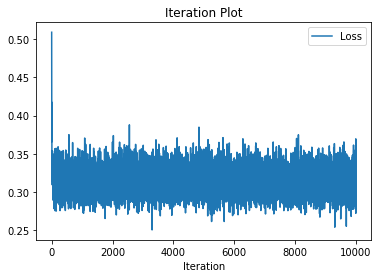

In [12]:
grad_descent(X, y, LEARN_RATE, MAX_ITERS, sgd_mini_batch_n=1000)

#### Execute L2 penalized stochastic gradient descent

Iteration history:
iter=0 loss=0.461673
iter=1000 loss=0.329070
iter=2000 loss=0.343811
iter=3000 loss=0.327983
iter=4000 loss=0.312636
iter=5000 loss=0.305115
iter=6000 loss=0.331027
iter=7000 loss=0.327247
iter=8000 loss=0.315605
iter=9000 loss=0.299981

Model parameters at iteration 9999:
[-0.01053456  0.04711783  0.41437448 -0.03713669  0.08668208  0.02662558
  0.0852053   0.04509276  0.0109407   0.31120157  0.03936369]

Model trained in 14.53 s.


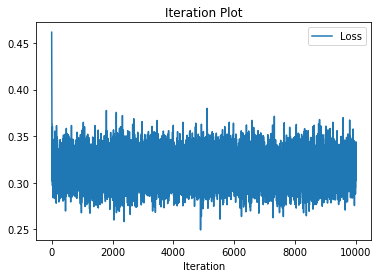

In [13]:
grad_descent(X, y, LEARN_RATE, MAX_ITERS, lambda_=0.01, sgd_mini_batch_n=1000)

### Use h2o to check model parameters

In [14]:
# start h2o
h2o.init()

DROPS = ['id', 'GRP_REP_home_ownership', 'GRP_addr_state', 'GRP_home_ownership',
         'GRP_purpose', 'GRP_verification_status', '_WARN_']

# numeric columns 
train = h2o.import_file(IN_FILE_PATH)
train = train.drop(DROPS)
X = train.col_names

# initialize non-penalized GLM model
loan_glm = H2OGeneralizedLinearEstimator(family='gaussian',      # uses squared error
                                         solver='IRLSM',         # necessary for non-penalized GLM
                                         standardize=False,      # data is already standardized
                                         compute_p_values=True,  # necessary for non-penalized GLM 
                                         lambda_=0)              # necessary for non-penalized GLM

# train 
loan_glm.train(train.col_names, Y, training_frame=train)

# print trained model info
print() 
print('Model parameters:')
for name, val in loan_glm.coef().items():
    print(name, val)
print()

# shutdown h2o
h2o.cluster().shutdown()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_171"; Java(TM) SE Runtime Environment (build 1.8.0_171-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.171-b11, mixed mode)
  Starting server from /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpfk6et3so
  JVM stdout: /tmp/tmpfk6et3so/h2o_patrickh_started_from_python.out
  JVM stderr: /tmp/tmpfk6et3so/h2o_patrickh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,3 months and 14 days !!!
H2O cluster name:,H2O_from_python_patrickh_2x3z4e
H2O cluster total nodes:,1
H2O cluster free memory:,3.422 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%

Model parameters:
Intercept -0.009531837795372164
bad_loan 0.049491736160435965
STD_IMP_REP_annual_inc 0.41843440383338865
STD_IMP_REP_delinq_2yrs -0.04237426505134888
STD_IMP_REP_dti 0.08966404330351394
STD_IMP_REP_emp_length 0.030142903020478125
STD_IMP_REP_int_rate 0.08011731349769513
STD_IMP_REP_longest_credit_lengt 0.05023821933458795
STD_IMP_REP_revol_util 0.015542387042639218
STD_IMP_REP_term_length 0.31239210762608416
STD_IMP_REP_total_acc 0.04139276773790677

H2O session _sid_84a9 closed.
